# Example: Analysis of Put Credit Vertical Spreads
In this example, we will analyze vertical bullish credit spreads. These are directional options strategies that involve selling a higher strike put and buying a lower strike put, the high-strike is near the money and the low-strike is out of the money.

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> * __Construct profit diagrams for put vertical spreads:__ Build profit and loss profiles for put credit spreads by combining short and long put contracts with different strike prices, and compute the breakeven point where the position transitions from profit to loss.
> * __Calculate probability of profit and probability of exercise for vertical spreads:__ Use cumulative distribution functions of projected share price distributions to determine the likelihood of profit at the breakeven point, and compute the probability that at least one leg will expire in-the-money.
> * __Compute Delta for composite positions to assess hedging requirements:__ Calculate the net Delta for a put vertical spread by summing the weighted Deltas of individual legs, and determine whether the position is delta-neutral or requires hedging with underlying shares.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the data in the `metadata::Dict{String,Any}` and `optionschain::DataFrame` variables.

In [2]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="amd");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the metadata dictionary?

In [3]:
metadata |> keys

KeySet for a Dict{String, Any} with 10 entries. Keys:
  "DTE"
  "purchase_date"
  "historical_volatility"
  "underlying_share_price_ask"
  "source"
  "underlying_share_price_bid"
  "is_weekly"
  "atm_IV"
  "expiration_date"
  "underlying_share_price_mid"

What about the optionschain variable?

In [4]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


In [5]:
let
        
        # initialize -
        δ = 0.25; # set the delta for ATM search
        options_chain = optionschain;
        Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 10-22-2025

        # Next, let's find contracts that are at-the-money (ATM) or near-the-money (NTM) -
        atm_call_options = filter(row -> abs((row[:Strike] - Sₒ)/Sₒ) < δ, options_chain);
end

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,170.0,0.2568,62.7,63.0,63.3,61.6,30,"5,658",0.6574,0.9013,Call
2,175.0,0.2349,58.4,58.68,58.95,58.1,14,"3,244",0.6473,0.8835,Call
3,180.0,0.2131,54.2,54.45,54.7,54.58,45,"13,732",0.6439,0.8617,Call
4,185.0,0.1912,50.1,50.33,50.55,50.52,27,"4,132",0.6359,0.839,Call
5,190.0,0.1694,46.2,46.45,46.7,46.58,42,"10,147",0.6277,0.8141,Call
6,195.0,0.1475,42.45,42.65,42.85,42.37,34,"2,922",0.6149,0.7884,Call
7,200.0,0.1256,38.9,39.08,39.25,39.1,303,"8,795",0.6111,0.7581,Call
8,210.0,0.0819,32.35,32.43,32.5,32.1,88,"8,251",0.6008,0.693,Call
9,220.0,0.0382,26.5,26.6,26.7,26.5,160,"7,817",0.5922,0.6222,Call


### Constants
Let's set a value for the step size `Δt`, i.e., `1 day` in units of years (assuming a `365-day` year), and the risk-free rate at the time we gathered the data for the option contracts; we approximate this value using the [yield on the 10-year Treasury Note](https://ycharts.com/indicators/10_year_treasury_rate). We also set a value for the underlying share price `Sₒ` and the number of levels in the binomial tree model, `h`; we assume 6 levels per day.

In [6]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 10-22-2025

225.78

Other constants:

In [7]:
Δt = (1/365); # options use 365 day year
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
h = 366; # 6-points per trading day

In this example, we'll need to do a projection of the future share price distribution at the contract's expiration date. We'll use a Geometric Brownian Motion (GBM) model to project the future share price distribution at expiration.

Let's load the single asset geometric Brownian motion (SAGBM) parameters which we estimated a few lectures ago, which include the drift and diffusion coefficients for each ticker. We'll store this data in the `parameters_df::DataFrame` variable:

In [8]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

We are looking at `AMD`, so let's see what the parameters for this ticker are:

In [9]:
filter(:ticker=> x-> x=="AMD", parameters_df)

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,AMD,0.439658,1.96,0.437351,0.441964,0.474197


### Contract models
Next, we construct contract models for the options in this example. We begin by building an instance of the [MyAmericanPutContractModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}). 

The [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}) takes two arguments: the type to build, and a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) containing the strike price `K`, the `premium` paid for the option, the days to expiration `DTE` (units: years), the `sense = 1` (long), the number of contracts in the `copy` field and the implied volatility in the `IV` field.

We save the __short__ put option contract model in the `short_put_option_model` variable:

In [10]:
put_contract_model_short = let

    # initialize -
    K = 220.0; # strike price (TODO: update this value based on chosen strike price)
    options_dataset =  optionschain;
    premium = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];
    IV = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:IV]; # convert to decimal
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    θ = -1; # short position
    

    # build the contract model -
    put_option_model = build(MyAmericanPutContractModel, (
        K = K, 
        premium = premium, # mark price
        DTE = DTE*Δt, # units: years
        sense = θ,
        copy = 1,
        IV = IV
    ));

    put_option_model; # return the model -
end

MyAmericanPutContractModel(220.0, -1, 0.1589041095890411, 0.5903, 16.33, nothing, 1)

Next, let's build the __long__ put option contract model for the lower strike price in the vertical spread. Let's save the long put option contract model in the `long_put_option_model` variable:

In [11]:
put_contract_model_long = let

    # initialize -
    K = 210.0; # strike price (TODO: update this value based on chosen strike price)
    options_dataset =  optionschain;
    premium = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];
    IV = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:IV]; # convert to decimal
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    θ = 1; # long position

    # build the contract model -
    put_option_model = build(MyAmericanPutContractModel, (
        K = K, 
        premium = premium, # mark price
        DTE = DTE*Δt, # units: years
        sense = θ,
        copy = 1,
        IV = IV
    ));

    put_option_model; # return the model -
end

MyAmericanPutContractModel(210.0, 1, 0.1589041095890411, 0.5956, 12.18, nothing, 1)

___

## Task 1: Compute Profit, Loss and Breakeven Points
In this task, we compute the profit and loss (P&L) profile for the vertical credit spread position at expiration, as well as the breakeven points.

A put vertical spread is constructed by combining 2 $\times$ put contracts, a short put contract generates income while the long put contract controls downside risk. This trade has a bullish outlook on the underlying asset.

> __Bullish put credit spread:__ 
> 
> Let's build a bullish put credit spread for AMD whose current share price is $S(0) = 225.78$ USD/share. This trade structure is constructed by selling (short) a put with strike $K_{1}$ and buying (long) a put with strike $K_{2}$. 
> 
> * Leg 1: The strike price for the short put leg is given by $K_{1}$ = 220 USD/share with DTE = 58 days
> * Leg 2: The strike price for the long put leg is given by $K_{2}$ = 210 USD/share with DTE = 58 days
> 
> This trade will generate a net credit when opened. Depending on the share price at expiration, the trade can result in a profit or loss. The maximum profit occurs when the share price at expiration is above the higher strike price $K_{1}$. The maximum loss occurs when the share price at expiration is below the lower strike price $K_{2}$.


### Profit and Breakeven Analysis for Put Vertical Spread
Let contract $j$ have a strike price of $K_{j}$ and premium $\mathcal{P}_{j}$. The share price at expiration is given by $S(T)$. Finally, let contract 1 be the short leg $\theta_{1} = -1$ and contract 2 be the long leg $\theta_{2} = 1$, where $K_{2} < K_{1} < S_{\circ}$. Then, the profit for a single put vertical spread at expiration is given by:

$$
\hat{P}_{\mathcal{C}} = \left(K_{2} - S(T)\right)^{+} - \left(K_{1} - S(T)\right)^{+} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)
$$

where $V_{p}(K,S(T)) = (K-S(T))^{+}=\max(K-S(T),0)$ is the payoff function for a put contract. The first term is the net payout of the two legs of the spread, while the second term is the net premium received. The maximum possible profit, loss, and breakeven conditions are given by:

* The maximum possible profit of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S(T)\geq{K_{1}}$.
* The maximum possible loss of $K_{2} - K_{1} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S(T)\leq{K_{2}}$.
* The vertical put spread will breakeven when $S(T) = K_{1}+\left(\mathcal{P}_{2} - \mathcal{P}_{1}\right)$.

Let's visualize the profit and loss profile for the put vertical spread position.

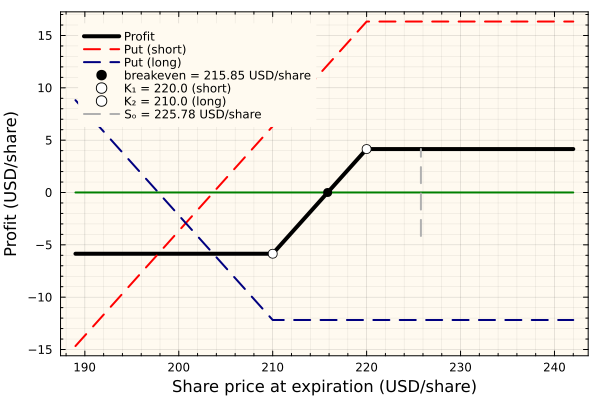

In [12]:
let

    # initialize -
    options_dataset =  optionschain;
    premium_1 = put_contract_model_short.premium;
    premium_2 = put_contract_model_long.premium;
    K₁ = put_contract_model_short.K;
    K₂ = put_contract_model_long.K;
     
    max_loss = K₂ - K₁ + (premium_1 - premium_2);
    max_profit = (premium_1 - premium_2);
    
    
    S = range(0.9*K₂,stop = 1.1*K₁, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model_short, put_contract_model_long], S);
    breakeven = K₁ + (premium_2 - premium_1)
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Put (long)", ls=:dash, c=:navyblue)
    
    plot!(S,BEL,lw=2, c=:green, label="")
    scatter!([breakeven], [0], c=:black, label="breakeven = $(breakeven) USD/share", ms=5)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short)", msc=:black, mc=:white)
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (long)", msc=:black, mc=:white)

    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, 
        label="Sₒ = $(Sₒ) USD/share", xminorticks=true, yminorticks=true, minorgrid=true)
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

The breakeven point can be derived by setting the profit function equal to zero and solving for $S(T)$:

In [13]:
let
    # initialize -
    options_dataset =  optionschain;
    premium_1 = put_contract_model_short.premium;
    premium_2 = put_contract_model_long.premium;
    K₁ = put_contract_model_short.K;
    K₂ = put_contract_model_long.K;
    breakeven = K₁ + (premium_2 - premium_1)
    println("The breakeven point is at S(T) = $(breakeven) USD/share")
end

The breakeven point is at S(T) = 215.85 USD/share


## Task 2: Compute the Probability of Profit (POP) and the Probability of Exercise (POE)
In this task, we compute the Probability of Profit (POP) and the Probability of Exercise (POE) for the put vertical spread position at expiration.

To start, we need to compute the distribution of future share prices at expiration using the SAGBM model parameters we loaded earlier. We use a Monte Carlo simulation to generate a large number of possible future share prices at expiration, and then compute the cumulative distribution function (CDF) of the future share prices.

In [14]:
model = let

    # Initialize -
    ATM_IV = metadata["atm_IV"] |> x-> parse(Float64, x); # atm IV on purchase date, 10-22-2025

    # Case: drift = risk-free rate, volatility = max (atm_IV, historic volatility)
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate, # let's mess with this ...
        σ = max(ATM_IV, filter(:ticker=> x-> x=="AMD", parameters_df)[!,:volatility] |> first)
    ));

    model;
end

MyGeometricBrownianMotionEquityModel(0.0431, 0.5903)

Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `AMD` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (col 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint::Array{Float64,1}` variable.

So what do we get?

In [15]:
endpoint_samples = let

    # initialize
    number_of_samples = 50000; # how many samples do we want to generate?
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)

    # compute the endpoint samples -
    endpoint = VLQuantitativeFinancePackage.sample(model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths


    println("The mean projected price for GBM: $(mean(endpoint))");

    endpoint; # return
end;

The mean projected price for GBM: 227.13595710373812


#### Check: Are future GBM share prices log-normally distributed?
We expect geometric Brownian motion to generate __log-normally distributed__ share prices. However, we can check this expectation by performing an [exact one-sample Kolmogorov-Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#Kolmogorov-Smirnov-test) on the samples and a [LogNormal distribution estimated using maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). 
> __Hypothesis:__ The `H0:null hypothesis` for the test is the data (endpoint samples generated using geometric Brownian motion) comes from the LogNormal distribution `d`. The alternative hypothesis `H1:alternative` is the samples are not drawn from the distribution `d`.

Let's start this check by fitting a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [16]:
d_gbm = fit_mle(LogNormal, endpoint_samples);

Next, execute [the exact one-sample Kolmogorov–Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.ExactOneSampleKSTest) and check the [pvalue](https://en.wikipedia.org/wiki/P-value) using the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). We reject the `H0:null hypothesis`, i.e., the `endpoint` samples are not drawn from `d_gbm`, if the `pvalue` generated by the test is _less than_ some confidence cutoff, e.g., `99%` or `0.01`.

In [17]:
test_result = ExactOneSampleKSTest(endpoint_samples, d_gbm)

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00269348

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.8612

Details:
    number of observations:   50000


`Unhide` the code block below to see how we plotted the future share price of `AMD` generated using a risk-neutral single asset geometric Brownian motion model parameterized using historical volatility.
> __What do we see?__ The geometric Brownian motion generates future share prices that are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the check above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution produces a model that describes the simulated endpoint share prices (red line).

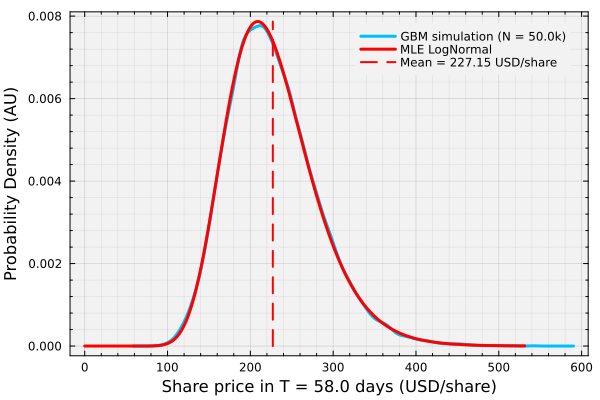

In [18]:
let

    # setup the mean line (for plotting) -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_gbm);
    LY = range(0, stop = maximum(pdf.(d_gbm, range(quantile(d_gbm,0.01), stop=quantile(d_gbm,0.99), length=100))), length = 100) |> collect;

    # plot -
    density(endpoint_samples, lw=3, c=:deepskyblue1, label="GBM simulation (N = $(length(endpoint_samples)/1000)k)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, xminorgrid = true, yminorgrid = true)
    
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_gbm),digits=2)) USD/share")
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Alternative: Future share price projection using implied volatility
Alternatively, we could use the __implied volatility__ to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where the mean $\mu_{IV} = S_{0}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{0}$ for short duration contracts, and the standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{0}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). This is only an approximate model of the future share price; it has a couple of issues: 
> __Watch out!__ This model assumes a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal), which is problematic because it can emit negative share prices. One way to fix this issue is to use a [Truncated Normal distribution](https://juliastats.org/Distributions.jl/stable/truncate/#Truncated-Distributions) instead.

However, despite the potential issues, this model is __widely__ used to generate quick estimates of future share price ranges using the forward-looking implied volatility. Let's save the Normal IV distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable:

In [19]:
d_IV = let

    # initialize -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    ATM_IV = metadata["atm_IV"] |> x-> parse(Float64, x); # atm IV on purchase date, 10-22-2025
    
    # build the Normal model -
    d = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(ATM_IV)*sqrt(DTE*Δt));
    d; # return

end

Normal{Float64}(μ=227.33162192473233, σ=53.12828738827033)

`Unhide` the code block below to see how we plotted the `d_gbm` and `d_IV` future share price densities at `T = 58 days`.  

> __What do we see?__ The log-normal GBM share price distribution (blue line) is right-skewed and cannot admit negative share prices. However, the Normal IV distribution (red line) is symmetric around the mean future share price and can admit negative share prices, albeit with a small probability.

How do the two distributions compare?

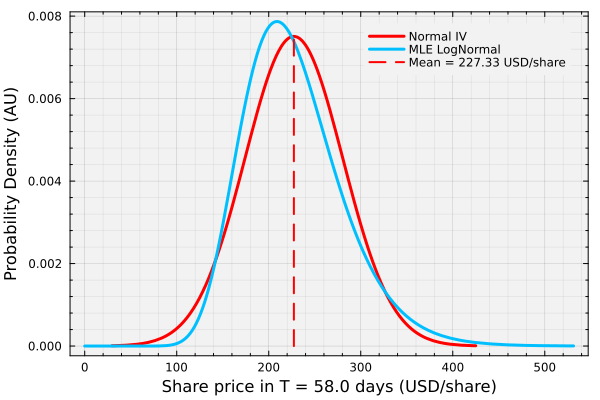

In [20]:
let

    # initialize -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_IV);
    LY = range(0, stop = maximum(pdf.(d_IV, range(quantile(d_IV,0.01), stop=quantile(d_IV,0.99), length=100))), length = 100) |> collect;

    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, minorgrid = true);
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_IV),digits=2)) USD/share")
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Probability of Profit (POP)
The POP for a put credit vertical spread position is given by the probability that the future share price at expiration $S(T)$ is larger than the breakeven point.

> __Probability of Profit (POP) for Vertical Spread__ 
> 
> The POP for a put vertical spread position is the probability that the future share price at expiration $S(T)$ is greater than the breakeven point $B$:
> $$
\begin{align*}
\text{POP} &= \mathbb{P}(S(T) > B) \\
& = 1 - \mathbb{P}(S(T) \leq B)
\end{align*}
$$
> where $F_{S}(x)$ is the cumulative distribution function (CDF) of the future share price at expiration, i.e., $F_{S}(x) = \mathbb{P}(S(T) \leq x)$.

In [23]:
pop_put_vertical_spread = let

    # initialize -
    future_share_price_distribution = d_gbm;
    options_dataset =  optionschain;
    premium_1 = put_contract_model_short.premium;
    premium_2 = put_contract_model_long.premium;
    K₁ = put_contract_model_short.K;
    K₂ = put_contract_model_long.K;
    breakeven = K₁ + (premium_2 - premium_1)
    
    # compute the POP -
    POP = 1 - cdf(future_share_price_distribution, breakeven)
    println("The Probability of Profit (POP) for the put vertical spread is $(round(POP*100,digits=2)) %")
end

The Probability of Profit (POP) for the put vertical spread is 53.91 %


What is the probability of exercise (POE) for the put vertical spread position? The short put contract will be exercised if the share price at expiration is below the strike price of the short put contract, i.e., $S(T) < K_{1}$. The long put contract will be exercised if the share price at expiration is below the strike price of the long put contract, i.e., $S(T) < K_{2}$.

Since $K_{2} < K_{1}$, if the long put is in-the-money, the short put is also in-the-money. Therefore, the overall POE for the put vertical spread position is determined by the short put at the higher strike:
$$
\begin{align*}
\text{POE} & = \mathbb{P}(S(T) \leq (K_{1} - 0.01)) \\
& = F_{S}(K_{1} - 0.01)
\end{align*}
$$
where $F_{S}(x)$ is the cumulative distribution function (CDF) of the future share price at expiration, i.e., $F_{S}(x) = \mathbb{P}(S(T) \leq x)$.

In [47]:
poe_put_vertical_spread = let

    # initialize -
    future_share_price_distribution = d_IV;
    options_dataset =  optionschain;
    premium_1 = put_contract_model_short.premium;
    premium_2 = put_contract_model_long.premium;
    K₁ = put_contract_model_short.K;
    K₂ = put_contract_model_long.K;
    
    # compute the POE -
    POE = cdf(future_share_price_distribution, K₁ - 0.01) # slightly less than K₁ 
    println("The Probability of Expiring In-the-Money (POE) for the put vertical spread is $(round(POE*100,digits=2)) %")
end

The Probability of Expiring In-the-Money (POE) for the put vertical spread is 44.5 %


___

## Task 3: Is this trade Delta-neutral?
In this task, we determine if the put vertical spread position is Delta-neutral at the time of trade initiation. A position is considered Delta-neutral if the overall Delta of the position is zero.

The net Delta of a put vertical spread equals the sum of the individual Deltas of the short and long put contracts. A negative net Delta indicates the position benefits from a decrease in the underlying share price, while a positive net Delta indicates the position benefits from an increase in the share price.

Let's compute the Delta of the short put contract.

In [38]:
delta_put_contract_short = let

    # initialize
    greek_value = 0.0; # initially set the greek value to 0
    contract_model = put_contract_model_short; # alias the contract model
    contract_model.sense = 1; # set to long position for greek calculation

    # call the greek function
    greek_value = delta(contract_model, h = h,  T = contract_model.DTE, 
        σ = contract_model.IV, Sₒ = Sₒ, μ = risk_free_rate);

    # this is short position, so negate the value

    # return -
    greek_value;
end

-0.38000000000000256

Now let's compute the Delta of the long put contract.

In [32]:
delta_put_contract_long = let

    # initialize
    greek_value = 0.0; # initially set the greek value to 0
    contract_model = put_contract_model_long; # alias the contract model

    # call the greek function -
    greek_value = delta(contract_model, h = h,  T = contract_model.DTE, 
        σ = contract_model.IV, Sₒ = Sₒ, μ = risk_free_rate);

    # return -
    greek_value;
end

-0.33000000000000007

Now let's compute the overall Delta of the put vertical spread position by summing the Deltas of the short and long put contracts. If the overall Delta is close to zero, then the position is Delta-neutral.

In [42]:
(-1*delta_put_contract_short + delta_put_contract_long) |> x-> round(x,digits=4)

0.05

___

## Summary
This example demonstrates how to construct and analyze a put credit vertical spread position using profit diagrams, probability calculations, and Delta analysis.

> __Key Takeaways:__
>
> * __Put vertical spreads have defined risk and reward boundaries:__ The maximum profit equals the net credit received from selling the higher strike put and buying the lower strike put, occurring when the share price stays above the higher strike. The maximum loss equals the difference between strike prices minus the net credit, occurring when the share price falls below the lower strike.
> * __Probability measures assess position risk from different perspectives:__ Probability of profit evaluates the likelihood that the share price remains above the breakeven point at expiration. Probability of exercise estimates the likelihood that the short leg will be assigned, requiring the trader to buy shares at the strike price.
> * __Delta indicates directional exposure and hedging requirements:__ The net Delta of a put vertical spread is calculated by summing the Deltas of the short and long legs. A non-zero net Delta indicates the position has directional exposure that can be hedged by holding shares of the underlying asset.

Understanding put vertical spreads enables traders to generate income while limiting downside risk in bullish market conditions.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.